# Actor Critic

In this notebook, we will implement Actor Critic algorithm to play Catpole.

## Step 1: Import the libraries

In [1]:
import time
import random
import gym
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple, deque

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.distributions import Categorical

## Step 2: Create our environment

In [3]:
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = gym.make('CartPole-v1')
env.seed(1)

c:\users\deepanshu\.conda\envs\ai\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[1]

## Step 3: Viewing our Enviroment
Execute the code cell below to play Cartpole with a random policy.

The size of state is:  (4,)
No. of Actions:  2


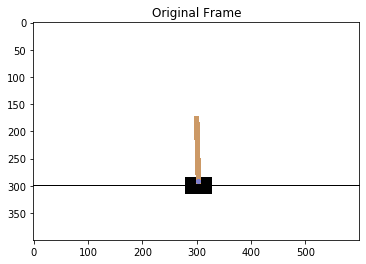

In [4]:
print("The size of state is: ", env.observation_space.shape)
print("No. of Actions: ", env.action_space.n)
env.reset()
plt.figure()
plt.imshow(env.render(mode='rgb_array'))
env.close()
plt.title('Original Frame')
plt.show()

In [5]:
def random_play():
    env.reset()
    while True:
        env.render(mode='rgb_array')
        action = env.action_space.sample()
        state, reward, done, _ = env.step(action)
        if done:
            env.close()
            break
random_play()

## Step 4: Creating Deep Learning Model

In [6]:
class Network(nn.Module):
    def __init__(self, state_size = 4, action_size=2):
        super(Network, self).__init__()
        self.action_size = action_size
        self.fc1 = nn.Linear(state_size, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, x):
        x = torch.from_numpy(x).float().unsqueeze(0).to(device)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        if self.action_size == 1:
            return x
        return F.softmax(x, dim=1)

## Step 6: Creating out agent

In [7]:
GAMMA = 0.99            # discount factor

class Agent():
    def __init__(self, state_size, action_size, alpha=0.0001, beta=0.0005):
        self.action_size = action_size
        self.state_size = state_size
        
        # Actor
        self.actor_net = Network(state_size, action_size).to(device)
        self.actor_optimizer = optim.Adam(self.actor_net.parameters(), lr=alpha)
        
        # Critic
        self.critic_net = Network(state_size, 1).to(device)
        self.critic_optimizer = optim.Adam(self.critic_net.parameters(), lr=beta)
        
        self.log_probs = None
        
                
    def act(self, state):
        """Returns actions for given state as per current policy."""
        probs = self.actor_net(state)
        action_probs = Categorical(probs)
        action = action_probs.sample()
        self.log_probs = action_probs.log_prob(action)
        return action.item()
        
    def step(self, state, reward, new_state, done):        
        self.actor_optimizer.zero_grad()
        self.critic_optimizer.zero_grad()
        
        cv_new_state = self.critic_net(new_state)
        cv_state = self.critic_net(state)
        
        reward = torch.tensor(reward, dtype=torch.float).to(device)
        
        delta = reward + GAMMA * cv_new_state * (1-int(done)) - cv_state
        
        actor_loss = -self.log_probs * delta
        critic_loss = delta**2
        
        (actor_loss + critic_loss).backward()
        
        self.actor_optimizer.step()
        self.critic_optimizer.step()

## Step 7: Watching untrained agent play

In [8]:
agent = Agent(state_size=4, action_size= env.action_space.n)

# watch an untrained agent
state = env.reset()
for j in range(200):
    action = agent.act(state)
    env.render()
    next_state, reward, done, _ = env.step(action)
    state = next_state
    time.sleep(0.05)
    if done:
        break 
        
env.close()

## Step 8: Loading Agent

In [9]:
start_epoch = 0
scores = []
scores_window = deque(maxlen=100)

# To Load checkpoint uncomment code
# checkpoint = torch.load('cartpole_ac_solved.pth')
# agent.actor_net.load_state_dict(checkpoint['actor_dict'])
# agent.actor_optimizer.load_state_dict(checkpoint['actor_optimizer'])
# agent.critic_net.load_state_dict(checkpoint['critic_dict'])
# agent.critic_optimizer.load_state_dict(checkpoint['critic_optimizer'])
# start_epoch = checkpoint['epoch']
# scores = checkpoint['scores']

# index = 1
# for i in reversed(scores):
#     scores_window.append(i)
#     if index == 100:
#         break
#     index += 1

## Step 9: Train the Agent with DQN

In [10]:
def train(n_episodes=2000):
    for i_episode in range(start_epoch+1, n_episodes+1):
        state = env.reset()
        score = 0
        while True:
            action = agent.act(state.copy())
            next_state, reward, done, _ = env.step(action)
            score += reward
            # reward = -100 if done and score < 450 else reward  
            agent.step(state, reward, next_state, done)
            state = next_state
            if done:
                break
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=490:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            state = {'epoch': i_episode,'actor_dict': agent.actor_net.state_dict(),'actor_optimizer': agent.actor_optimizer.state_dict(),
                     'critic_dict': agent.critic_net.state_dict(),'critic_optimizer': agent.critic_optimizer.state_dict(), 'scores': scores }
            torch.save(state, "cartpole_ac_solved.pth")
            break
    
    return scores

In [11]:
scores = train(2000)
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

Episode 1500	Average Score: 442.25
Episode 1545	Average Score: 440.58

KeyboardInterrupt: 

In [ ]:
# watch an trained agent
state = env.reset()
score = 0
while True:
    action = agent.act(state)
    env.render()
    next_state, reward, done, _ = env.step(action)
    score += reward
    state = next_state
    if done:
        print("Your score is: ", score)
        break 
        
env.close()